# MovieLens

27,000,000 ratings and 1,100,000 tag applications applied to 58,000 movies by 280,000 users. Includes tag genome data with 14 million relevance scores across 1,100 tags. Last updated 9/2018.

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
from os import path
import matplotlib
import matplotlib.pyplot as plt
import gc

%matplotlib inline
plt.rcParams["figure.figsize"] = [24, 18]

In [2]:
data_dir = 'ml-latest'

Movies Data File Structure (movies.csv)
---------------------------------------

Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,title,genres

Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)


In [1]:
!head  'ml-latest/movies.csv'

Tags Data File Structure (tags.csv)
-----------------------------------

All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

    userId,movieId,tag,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [2]:
!head  'ml-latest/tags.csv'

Ratings Data File Structure (ratings.csv)
-----------------------------------------

All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

    userId,movieId,rating,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [3]:
!head  'ml-latest/ratings.csv'

Links Data File Structure (links.csv)
---------------------------------------

Identifiers that can be used to link to other sources of movie data are contained in the file `links.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,imdbId,tmdbId

movieId is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

imdbId is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

tmdbId is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>.

Use of the resources listed above is subject to the terms of each provider.


In [4]:
!head  'ml-latest/links.csv'

Tag Genome (genome-scores.csv and genome-tags.csv)
-------------------------------------------------

This data set includes a current copy of the Tag Genome.

[genome-paper]: http://files.grouplens.org/papers/tag_genome.pdf

The tag genome is a data structure that contains tag relevance scores for movies.  The structure is a dense matrix: each movie in the genome has a value for *every* tag in the genome.

As described in [this article][genome-paper], the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

The genome is split into two files.  The file `genome-scores.csv` contains movie-tag relevance data in the following format:

    movieId,tagId,relevance

The second file, `genome-tags.csv`, provides the tag descriptions for the tag IDs in the genome file, in the following format:

    tagId,tag

The `tagId` values are generated when the data set is exported, so they may vary from version to version of the MovieLens data sets.

Please include the following citation if referencing tag genome data:

> Jesse Vig, Shilad Sen, and John Riedl. 2012. The Tag Genome: Encoding Community Knowledge to Support Novel Interaction. ACM Trans. Interact. Intell. Syst. 2, 3: 13:1–13:44. <https://doi.org/10.1145/2362394.2362395>

In [5]:
!head  'ml-latest/genome-tags.csv'

In [6]:
!head  'ml-latest/genome-scores.csv'

In [9]:
# df = pd.read_csv(path.join(data_dir,'ratings.csv'),nrows=5000000)
df = pd.read_csv(path.join(data_dir,'ratings.csv'))
df = df.drop(columns='timestamp')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
userId     int64
movieId    int64
rating     float64
dtypes: float64(1), int64(2)
memory usage: 635.2 MB


In [10]:
# оптимизируем память
def opt_mem_df(df):
    df = df.astype({"userId": int, 'movieId':int, "rating": float})
    # все int в unsigned
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')
    df[converted_int.columns] = converted_int
    del df_int, converted_int
    # понизить потребление памяти float, если возможно без потери точности
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric,downcast='float')
    df[converted_float.columns] = converted_float
    return df

df = opt_mem_df(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
userId     uint32
movieId    uint32
rating     float32
dtypes: float32(1), uint32(2)
memory usage: 317.6 MB


In [11]:
df.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


Загрузим словарь фильмов

In [12]:
df_movies = pd.read_csv(path.join(data_dir,'movies.csv'))

dict_movie = {row['movieId']:row['title'] for index,row in df_movies[['movieId','title']].iterrows()}
del df_movies
dict_movie[1]

'Toy Story (1995)'

In [13]:
len(dict_movie)

58098

## Оценить распределения

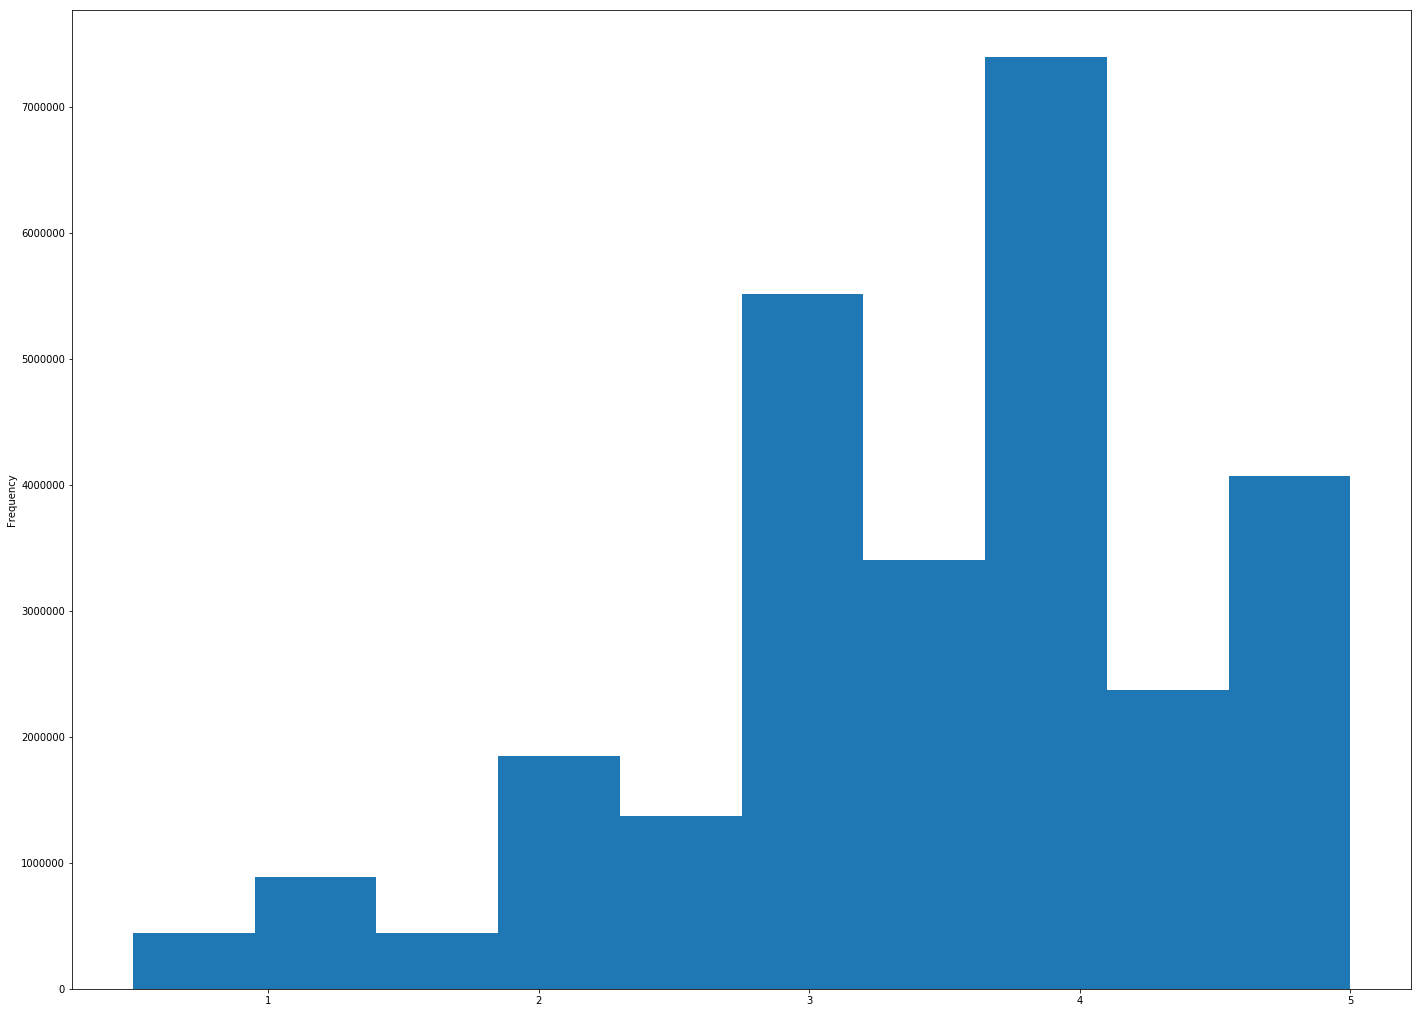

In [14]:
fig, ax = plt.subplots()
df['rating'].plot.hist(by='rating',ax=ax)

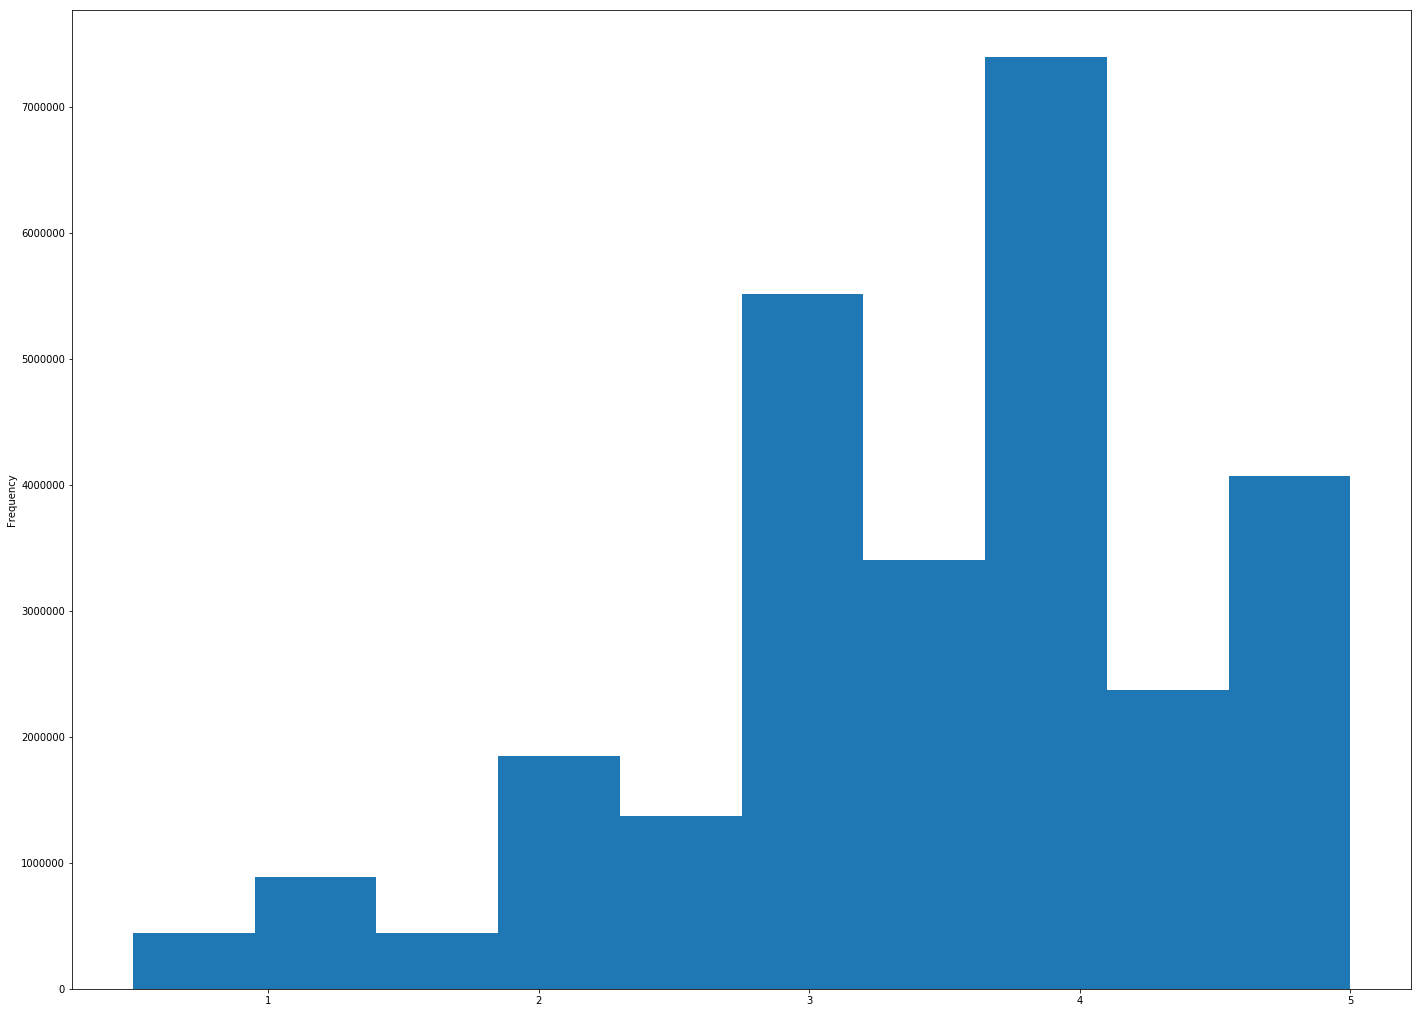

In [15]:
fig, ax = plt.subplots()
df['rating'].plot.hist(by='movieId',ax=ax)

Пользователи значительно реже ставят "половинки" баллов, Так же распределения не сводятся к нориальному, явная ассимитрия

## Оценить средние оценки

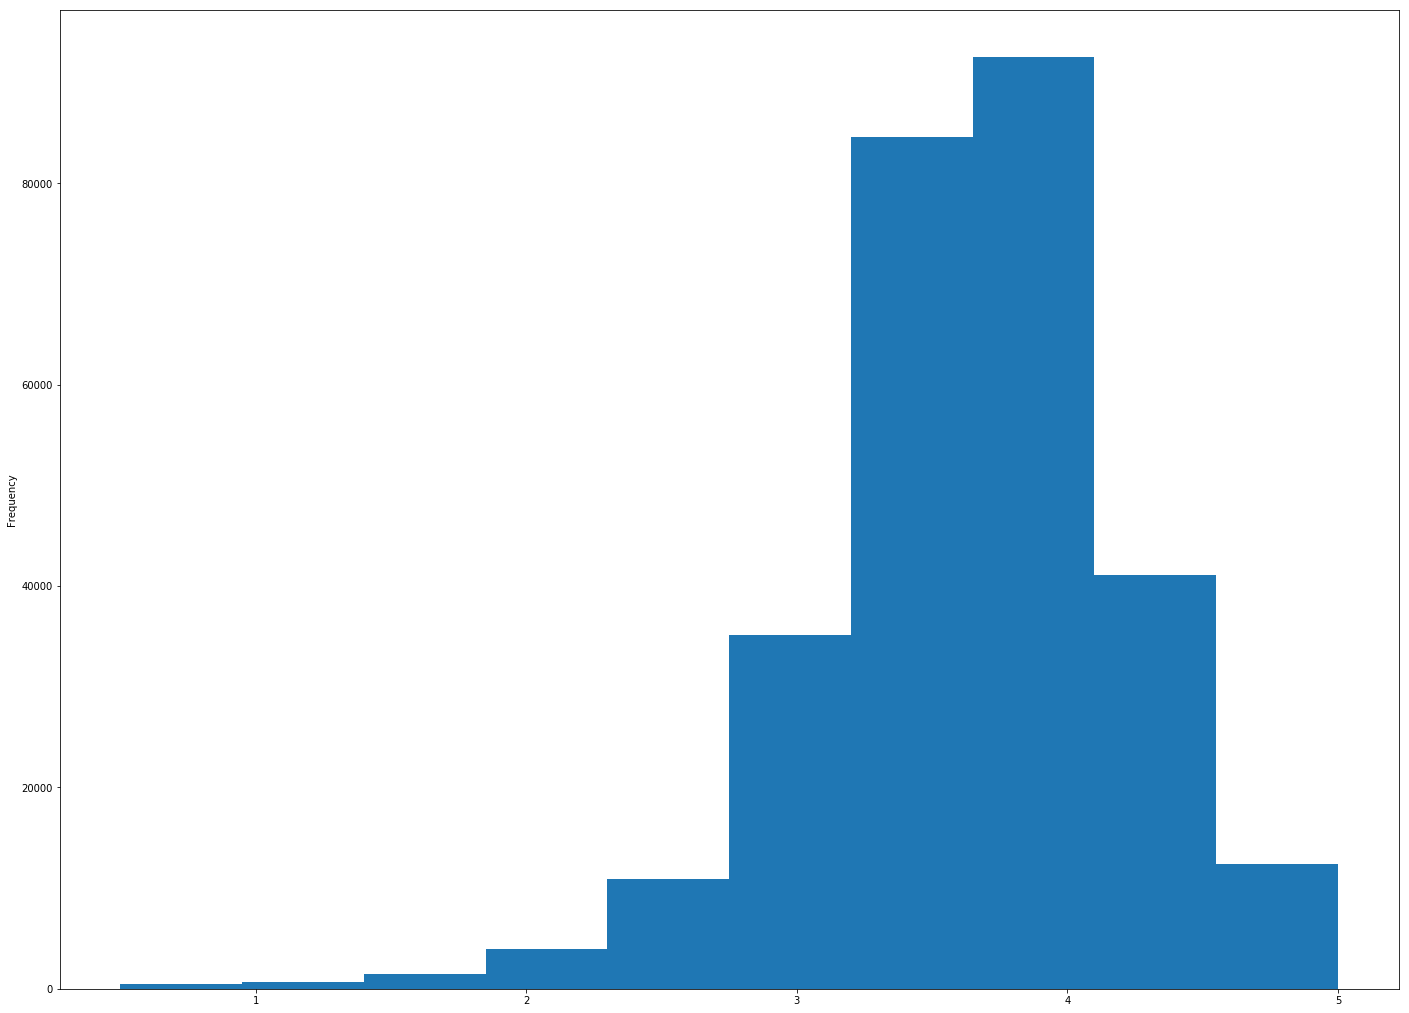

In [16]:
fig, ax = plt.subplots()
df.groupby(['userId'])['rating'].mean().plot.hist(ax=ax)

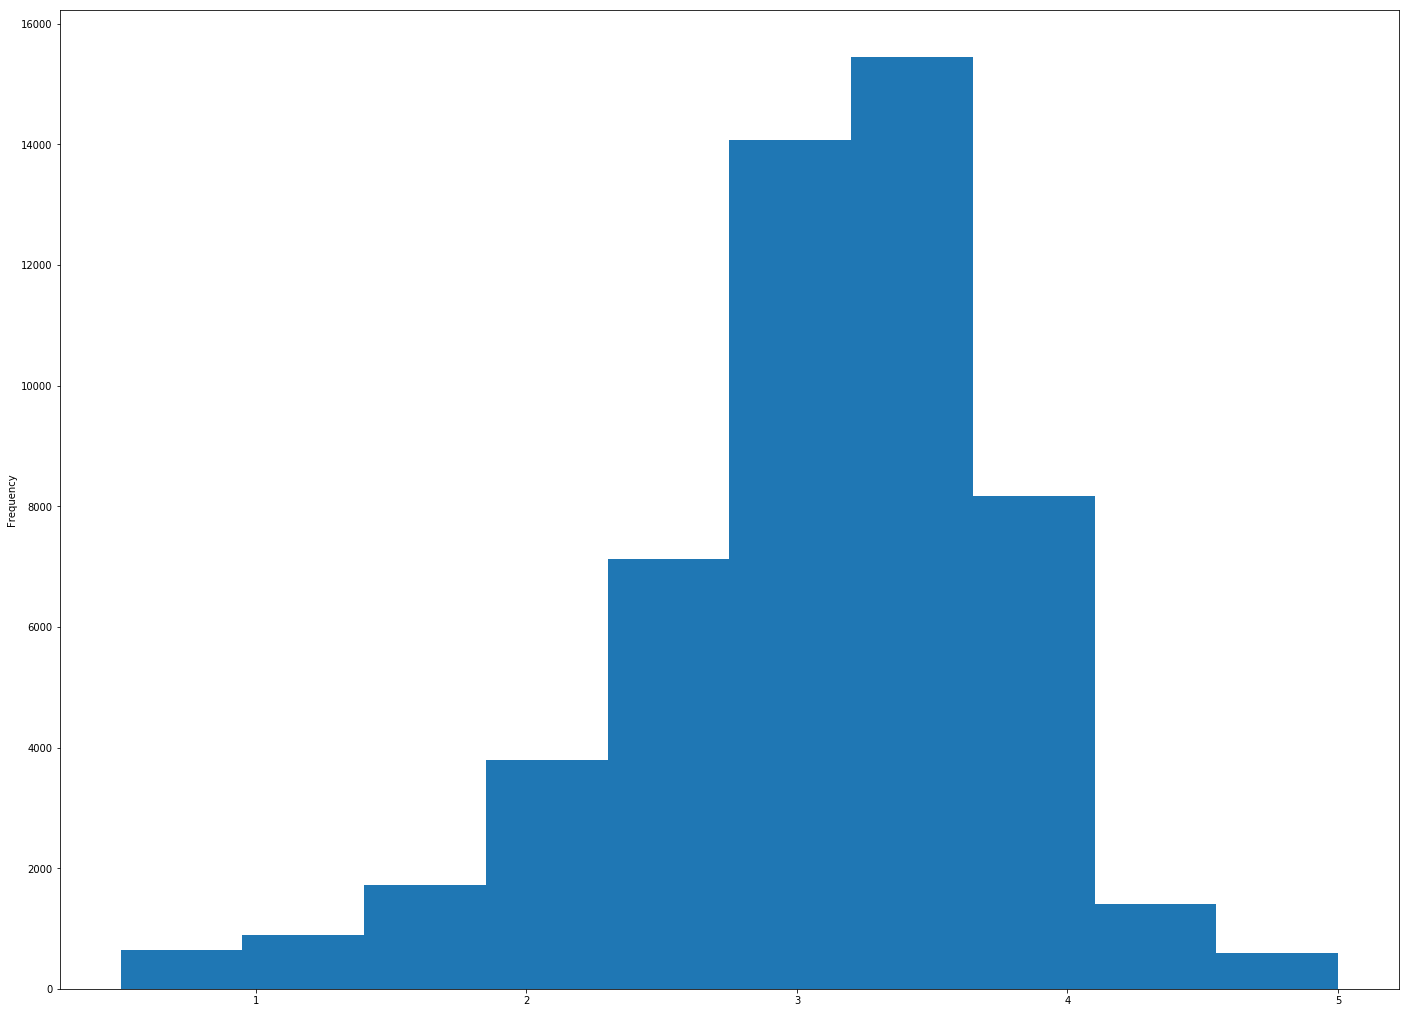

In [17]:
fig, ax = plt.subplots()
df.groupby(['movieId'])['rating'].mean().plot.hist(ax=ax)

In [18]:
del fig,ax

Опять таки распределения ассиметричны. Средние оценки пользователей ближе к 4, а фильмы к 3,5

## Выбрать критерий, показывающий, что фильм нравится всем, или не нравится никому

рейтинг фильмов должен быть устойчивым к числу посмотревших, поэтому с помощью логарифмической шкалы, отнормируем от 0 до 5, учтем среднюю оценку пользователей и разделим пополам, чтобы общий бал был от 0 до 5

In [19]:
alpha = np.log(np.power(np.max(df.groupby(['movieId'])['rating'].count()),1/5))

df_mr = pd.DataFrame((np.log(df.groupby(['movieId'])['rating'].count())/alpha+df.groupby(['movieId'])['rating'].mean())/2)
df_mr['title'] = [dict_movie[row] for row in df_mr.index]

In [20]:
df_mr.iloc[df_mr['rating'].argsort()[-10:]]

,rating,title
movieId,,
260,4.520964,Star Wars: Episode IV - A New Hope (1977)
356,4.526153,Forrest Gump (1994)
2959,4.528278,Fight Club (1999)
2571,4.542724,"Matrix, The (1999)"
50,4.547020,"Usual Suspects, The (1995)"
593,4.552046,"Silence of the Lambs, The (1991)"
527,4.560221,Schindler's List (1993)
858,4.562977,"Godfather, The (1972)"
296,4.574202,Pulp Fiction (1994)


The Usual Suspects и Schindler's List я не смотрел, остальные я в общем считаю одни из лучших, т.е. я согласен с оценками

In [21]:
df_mr.iloc[df_mr['rating'].argsort()[:10]]

,rating,title
movieId,,
129881,0.25,Il cappotto di legno (1981)
181463,0.25,Equilibrium (2017)
155737,0.25,Shana: The Wolf's Music (2014)
155731,0.25,12 Paces without a Head (2009)
181487,0.25,Killing American Style (1991)
155577,0.25,First Position
191265,0.25,Triassic World (2018)
155567,0.25,USS Seaviper (2012)
155539,0.25,Return to Nuke 'Em High Volume 2 (2014)


Вообще не знаю эти фильмы, кроме Equilibrium. Этот фильм оставил смешанные чувства, так что, пожалуй, соглашусь

In [22]:
del df_mr

In [23]:
gc.collect()

14

## Построение рекомендательной системы


Выберем пользователя и посмотрим о нем информацию

In [24]:
df[df['userId']==25]

,userId,movieId,rating
1918,25,1,4.0
1919,25,25,5.0
1920,25,32,3.0
1921,25,62,5.0
1922,25,79,3.0
1923,25,141,3.0
1924,25,260,5.0
1925,25,494,3.0
1926,25,628,3.0
1927,25,637,3.0


Заведем нового пользователя(себя) и поставим оценку фильму Звездные воины 4 эпизод (id=260). Так же поставим оценку другими пользователями самому лучшему и худшему фильму. Делаем на будущее, чтобы не переобучать модель

In [25]:
def add_user(df,data):
    df_new = pd.DataFrame(data,columns=['userId','movieId','rating'])
    return pd.concat([df,df_new], ignore_index=True)

new_user = int(np.max(df['userId']))+1


# df.loc[df.shape[0]] = [new_user, 260, 5.0]
data =[
    [new_user, 260, 5.0], # моя оценка
    [new_user+1, 296, 5.0], # оценка для лучшего фильма
    [new_user+2, 181463, 5.0] # оценка для худшего фильма
]
df = add_user(df,data)
df.loc[df.shape[0]-3:]

,userId,movieId,rating
27753444,283229,260,5.0
27753445,283230,296,5.0
27753446,283231,181463,5.0


In [26]:
df = opt_mem_df(df) # уменьшим память
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753447 entries, 0 to 27753446
Data columns (total 3 columns):
userId     uint32
movieId    uint32
rating     float32
dtypes: float32(1), uint32(2)
memory usage: 317.6 MB


In [27]:
from surprise import Dataset
from surprise import Reader

# преобразуем датасет пандаса в датасет библиотеки surprise
def df_to_data(df):
    reader = Reader(rating_scale=(0.5, 5))
    return Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
# reader = Reader(line_format='user item rating timestamp', sep=',',rating_scale=(0.5, 5),skip_lines=1)
# data = Dataset.load_from_file(path.join(data_dir,'ratings.csv'), reader=reader)

In [28]:
import pickle
from surprise import SVD
from surprise.model_selection import cross_validate, GridSearchCV

param_grid = {
    'lr_all': [0.005, 0.05],
    'reg_all': [0.02, 0.002],
    'n_factors': [5, 10, 100, 500],
    'n_epochs': [10, 100]
}


try:
    with open('svd.pkl','rb') as f: # есть ли лучшая модель?
        gs = pickle.load(f)
except FileNotFoundError: # в противном случае ищем
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, joblib_verbose=3,n_jobs=4)
    gs.fit(df_to_data)
    with open('svd.pkl','wb') as f:
        pickle.dump(gs,f)
        
del param_grid

# best RMSE score
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8228837817027087, 'mae': 0.6200950468217351}
{'rmse': {'lr_all': 0.005, 'reg_all': 0.02, 'n_factors': 10, 'n_epochs': 100}, 'mae': {'lr_all': 0.005, 'reg_all': 0.02, 'n_factors': 10, 'n_epochs': 100}}


In [29]:
# оценки кросвалидации, т.к. потребляет много памяти в 1 процесс, и сохраним результат
try:
    with open('cv.pkl',"rb") as f:
        cv = pickle.load(f)
except FileNotFoundError:
    svd = SVD(**gs.best_params['rmse'])
    cv = cross_validate(svd, df_to_data(df),  measures=['RMSE', 'MAE'], cv=5, verbose=True)
    with open('cv.pkl',"wb") as f:
        pickle.dump(cv,f)
    del svd
print(cv)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8049  0.8053  0.8060  0.8060  0.8045  0.8053  0.0006  
MAE (testset)     0.6055  0.6058  0.6062  0.6062  0.6053  0.6058  0.0004  
Fit time          1480.00 1518.84 1504.44 1511.25 1503.70 1503.65 13.02   
Test time         74.56   72.68   71.40   70.66   70.39   71.94   1.53    
{'test_rmse': array([0.80485324, 0.80528395, 0.80599014, 0.80595924, 0.80445027]), 'test_mae': array([0.60554361, 0.60582424, 0.60617726, 0.60623011, 0.60525486]), 'fit_time': (1480.0036962032318, 1518.8396301269531, 1504.4400990009308, 1511.246101140976, 1503.7023973464966), 'test_time': (74.55653715133667, 72.68166875839233, 71.39883756637573, 70.6554582118988, 70.38907980918884)}


In [30]:
def fit_svd(df, param, filename):
    """
    загружает обученную модель из фаила, если нет, то обучает и сохраняет
    """
    try:
        with open(filename,'rb') as f:
            svd = pickle.load(f)
    except FileNotFoundError:
        train_set = df_to_data(df).build_full_trainset()
        svd = SVD(**param)
        svd.fit(train_set)
        with open(filename,'wb') as f:
            pickle.dump(svd,f)
    return svd


In [31]:
svd = fit_svd(df,gs.best_params['rmse'],'svd_full.pkl')

In [32]:
# список интересующих пользователей
userIds = [25,283229,283230,283231,283232]

def get_predictions(userIds,svd,df):
    """
    Получает предсказания по всем фильмам, кроме просмотренных для пользователей из userIds
    """
    vector = []
    for userId in userIds:
        movieIds = np.array(df[df['userId']==userId]['movieId'])
        for movieId in dict_movie.keys():
            if movieId in movieIds:
                print(userId,'has already seen',dict_movie[movieId])
                continue
            vector.append((userId,movieId,svd.default_prediction()))

    return svd.test(vector)


predictions = get_predictions(userIds,svd,df)

25 has already seen Toy Story (1995)
25 has already seen Leaving Las Vegas (1995)
25 has already seen Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
25 has already seen Mr. Holland's Opus (1995)
25 has already seen Juror, The (1996)
25 has already seen Birdcage, The (1996)
25 has already seen Star Wars: Episode IV - A New Hope (1977)
25 has already seen Executive Decision (1996)
25 has already seen Primal Fear (1996)
25 has already seen Sgt. Bilko (1996)
25 has already seen Mission: Impossible (1996)
25 has already seen Rock, The (1996)
25 has already seen Twister (1996)
25 has already seen Independence Day (a.k.a. ID4) (1996)
25 has already seen Willy Wonka & the Chocolate Factory (1971)
25 has already seen Star Wars: Episode VI - Return of the Jedi (1983)
283229 has already seen Star Wars: Episode IV - A New Hope (1977)
283230 has already seen Pulp Fiction (1994)
283231 has already seen Equilibrium (2017)


In [33]:
from collections import defaultdict

def get_recomendations(predictions, n=10):
    """
    из предсказаний выдаем рекомендации топ n фильмов
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))


    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    for uid, user_ratings in top_n.items():
        print(uid, [dict_movie[iid] for (iid, _) in user_ratings])

get_recomendations(predictions, n=20)

25 ["You Don't Know Bo (2012)", 'Cosmos: A Spacetime Odissey', 'Rumble: The Indians Who Rocked the World (2017)', 'Story of Science, The (2010)', 'Liberation Day (2016)', 'Freedom on My Mind (1994)', 'Forsyte Saga, The (1967)', "Schindler's List (1993)", 'Forrest Gump (1994)', 'Shock and Awe: The Story of Electricity (2011)', 'Voices from the List (2004)', 'Inner Worlds, Outer Worlds (2012)', 'Bully for Bugs (1953)', 'Wetlands (2011)', 'The Thorn (1971)', 'Shawshank Redemption, The (1994)', 'Blood Brother (2013)', 'Louis Theroux: Under The Knife (2007)', "Bi, Don't Be Afraid (2010)", 'The Moromete Family (1987)']
283229 ['Story of Science, The (2010)', 'Liberation Day (2016)', 'The Moromete Family (1987)', 'Freedom on My Mind (1994)', 'Band of Brothers (2001)', 'Inner Worlds, Outer Worlds (2012)', 'Planet Earth II (2016)', 'Frozen North, The (2006)', 'Forsyte Saga, The (1967)', 'Loot (1970)', 'Cosmos: A Spacetime Odissey', 'The Thorn (1971)', 'Earth: The Power of the Planet (2007)', 'D

* 283229 Я отметил Звездные Воины 4. С одной стороны, система могла бы предложить другие части саги. С другой стороны она предлагает в основном фильмы про космос, даже научные. В целом мне рекомендации не нравятся
* 283230 В качестве лучшего фильма я отметил за другого пользователя Криминальное чтиво. Однако рекомендации не сильно отличаются от пользователя по умолчанию 283232
* 283231 В качестве оценки по худшему фильму был Эквилибриум. так же не сильно отличаются от пользователя по умолчанию

In [34]:
del svd # очистим память

Поставим еще несколько оценок и посмотрим как изменятся рекомендации

In [35]:
data =[
    [new_user, 1196, 5.0], # SW5
    [new_user, 13, 4.0], # Balto 
    [new_user, 181463, 3.0], # Эквилиюриум
    [new_user, 1198, 4.0], # Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
    [new_user, 1210, 5.0], # SW6
    [new_user, 1036, 4.5], # Die Hard (1988)
    [new_user, 296, 5.0], # Pulp Fiction (1994)
    [new_user, 8371, 4.5], # Chronicles of Riddick, The (2004)
    [new_user, 4011, 5.0], # Snatch
]
df = add_user(df,data)
df = opt_mem_df(df)

In [36]:
svd = fit_svd(df,gs.best_params['rmse'],'svd_add.pkl')

In [37]:
userIds=[new_user]
predictions = get_predictions(userIds,svd,df)
get_recomendations(predictions, n=20)

283229 has already seen Balto (1995)
283229 has already seen Star Wars: Episode IV - A New Hope (1977)
283229 has already seen Pulp Fiction (1994)
283229 has already seen Die Hard (1988)
283229 has already seen Star Wars: Episode V - The Empire Strikes Back (1980)
283229 has already seen Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
283229 has already seen Star Wars: Episode VI - Return of the Jedi (1983)
283229 has already seen Snatch (2000)
283229 has already seen Chronicles of Riddick, The (2004)
283229 has already seen Equilibrium (2017)
283229 ['Matrix, The (1999)', 'Fight Club (1999)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Lord of the Rings: The Two Towers, The (2002)', 'Lord of the Rings: The Return of the King, The (2003)', 'Il Mare (Siworae) (2000)', 'Whole Night, A (Toute une nuit) (1982)', 'Shouting Fire: Stories from the Edge of Free Speech (2009)', 'Car Bonus (Autobonus) (2001)', 'Frozen North, The (2006)', "Grin Wit

In [38]:
del svd

Рекомендации улучшились, в топ вошли Матрица, Бойцовский клуб и Властелин колец, что в общем являются фэнтази или фантастикой, так же к боевикам. Хотя опять таки нет еще трех эпизодов SW. 